In [3]:
import numpy as np
from qiskit import *
from random import random, randint
import matplotlib.pyplot as plt

# import feature map
from feature_mapping_initialize_method import *

In [4]:
# Preparing feature-mapped circuit
# Inputs: 
#   num_qubits: number of qubits (log_2 of number of features), 
#   feature_data: data pertaining to each feature
# Outputs: 
#   qc: prepared quantum circuit
def prepare_circuit(num_qubits, feature_data):
    feature_data = normalize_data(feature_data)
    q = QuantumRegister(num_qubits)
    qc = QuantumCircuit(q)
    qc.initialize(feature_data, qc.qubits)
    return qc

In [5]:
# Measures a quantum circuit and processes the output
# Inputs: 
#   circuit: quantum circuit
#   s: number of shots
# Outputs:
#   counts: dictionary of results from measuring the circuit
def process_output(circuit, s):
    
    arr = []

    simulator = Aer.get_backend('aer_simulator')

    job = execute(circuit, simulator, shots=s)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

# Classifies counts based on the parity of the bits
# Inputs:
#   counts: dictionary containing counts from the circuit
#   shots: number of shots used in measurement
# Outputs:
#   dictionary containing the probability distribution of the data falling into each class
def parity_probabilities(counts, shots=100):
    class_0 = 0
    class_1 = 0

    for keyBefore, value in counts.items():
        key = keyBefore.split()[0]
        temp = int(key[0]) ^ int(key[1])
        for i in range(2, len(key)):
            temp = temp ^ int(key[i])
        
        if temp == 0:
            class_0 += value
        else:
            class_1 += value
    return {0: class_0 / shots, 1: class_1 / shots}

# Performs a variational quantum circuit with arbitrary rotation gates
# Inputs:
#   register: quantum register for the qubits
#   angles: list of parameters to be applied with the rotation gates
#   qc: prepared quantum circuit
# Outputs:
#   parity_processed:
def rotation(num_qubits, angles, qc):

    measurement = ClassicalRegister(num_qubits)
    qc.add_register(measurement)
    for i in range(num_qubits): # adds rotation gates
        qc.ry(angles[i], i)
    
    for i in range(num_qubits - 1, 0, -1): # adds controlled X gates
        qc.cx(i, i - 1)

    qc.cx(0, num_qubits - 1)

    qc.measure_all()
    s = 100
    shots = process_output(qc, 100)
    
    parity_processed = parity_probabilities(shots) # processes with respect to parity
    return parity_processed

q = QuantumRegister(4)
initial_angles = [2 * np.pi * random() for _ in range(4)]
len(q)

4

In [6]:
# Calculates mean squared error 
# Inputs: 
#   shots_count: dictionary of probabilities
#   expected_value: either a 1 or a 0, corresponding to the data
# Outputs:
#   Mean squared error according to formula
def mse(shots_count, expected_value):
    probability_of_expected = shots_count[expected_value]
    return (1 - probability_of_expected) ** 2

# y_values are either 0, 1
# received_measurements are the dictionary of probabilities
def count_costs(x_values, y_values, angles, received_measurements):
    cost = 0

    for i in range(len(x_values)):
        cost += mse(received_measurements[i], y_values[i])
    
    return cost / len(x_values)
    

In [61]:
def cost_across_x(num_qubits, x, y, angles):
    measured = []
    for i in x:
        qc = prepare_circuit(num_qubits, i)
        measured.append(rotation(num_qubits, angles, qc))
    cost_count = count_costs(x, y, angles, measured)
    return cost_count

def optimize_angles(angles, cost, x_values, y_values, num_qubits, delta=0.3, learning_rate=0.7):
    new_angles = [angle + delta / 2 for angle in angles]
    new_cost = cost

    for i in range(len(angles)):
        step_up = [j for j in angles]
        step_up[i] += delta

        step_down = [j for j in angles]
        step_down[i] -= delta

        cost_up = cost_across_x(num_qubits, x_values, y_values, step_up)
        cost_down = cost_across_x(num_qubits, x_values, y_values, step_down)
        
        # angle_delta = (cost_up - cost_down) / (2 * delta)
        # new_angles.append(angles[i] - delta * angle_delta)
        
        if cost_up < new_cost:
            new_cost = cost_up
            new_angles = [angle for angle in step_up]
        if cost_down < new_cost:
            new_cost = cost_down
            new_angles = [angle for angle in step_down]
    # new_cost = cost_across_x(num_qubits, x_values, y_values, new_angles)

    return new_angles, new_cost
        

In [62]:
import matplotlib.pyplot as plt
# random samples, toy data
entries = 32

x = []
for _ in range(entries):
    temp = [20 * random() for _ in range(4)]
    while temp in x:
        temp = 20 * random()
    x.append(temp)

y = [randint(0, 1) for _ in range(entries)]

measured = []

num_qubits = int(np.log2(len(x[0])))

initial_angles = [2 * np.pi * random() for _ in range(num_qubits)]

for i in range(len(x)):
    qc = prepare_circuit(num_qubits, x[i])
    measured.append(rotation(num_qubits, initial_angles, qc))
    
cost = count_costs(x, y, initial_angles, measured)
costs = [cost]
angles = [initial_angles]

print(f"initial parameters and costs: ({initial_angles}, {cost})")
i = 0
while costs[-1] > 0.25:
    plt.clf()
    current_angles, current_cost = optimize_angles(angles[-1], costs[-1], x, y, num_qubits)
    angles.append(current_angles)
    costs.append(current_cost)
    # print(f"Iteration {i}: ({current_angles}, {current_cost})")
    
    i += 1

print(f"Iteration {i}: ({angles[-1]}, {costs[-1]})")

initial parameters and costs: ([5.349501059909796, 5.410710627269352], 0.29111562499999993)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

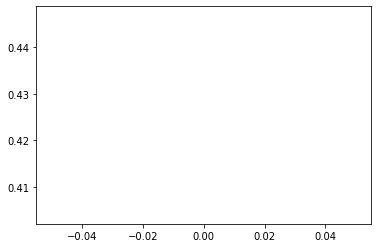

In [49]:
# x = [cost for cost in costs]
# y = [i for i in range(len(x))]

# plt.plot(y, x)


In [54]:
def train(x, y, max_it=300):
    measured = []

    num_qubits = int(np.log2(len(x[0])))

    initial_angles = [2 * np.pi * random() for _ in range(num_qubits)]

    for i in range(len(x)):
        qc = prepare_circuit(num_qubits, x[i])
        measured.append(rotation(num_qubits, initial_angles, qc))
        
    cost = count_costs(x, y, initial_angles, measured)
    costs = [cost]
    angles = [initial_angles]

    print(f"initial parameters and costs: ({initial_angles}, {cost})")
    i = 0
    while costs[-1] > 0.25:
        if (i > max_it):
            break
        # plt.clf()
        current_angles, current_cost = optimize_angles(angles[-1], costs[-1], x, y, num_qubits)
        angles.append(current_angles)
        costs.append(current_cost)
        print(f"Iteration {i}: ({current_angles}, {current_cost})")
        
        i += 1
        

    print(f"Iteration {i}: ({angles[-1]}, {costs[-1]})")
    x_costs = [cost for cost in costs]
    y_axis = [i for i in range(len(x))]

    plt.plot(y_axis, x_costs)

    return angles[-1]

In [59]:
# Fitting to data

import preprocesstest as preprocess

features_train, features_test, target_train, target_test = preprocess.filter("Data/testHeart.csv")
type(target_train)
target_train =  [item for sublist in target_train for item in sublist]
target_test = [item for sublist in target_test for item in sublist]

Column: Sex has ['M' 'F'] unique values

Column: ST_Slope has ['Up' 'Flat' 'Down'] unique values

Column: ChestPainType has ['ATA' 'NAP' 'ASY' 'TA'] unique values

Column: RestingECG has ['Normal' 'ST' 'LVH'] unique values

Column: ExerciseAngina has ['N' 'Y'] unique values

features_train <class 'list'>
features_test <class 'list'>
target_train <class 'list'>
target_test <class 'list'>


In [60]:
final_angles = train(features_train, target_train)
# measured = []

# num_qubits = int(np.log2(len(features_train[0])))

# initial_angles = [2 * np.pi * random() for _ in range(num_qubits)]

# for i in range(len(features_train)):
#     qc = prepare_circuit(num_qubits, features_train[i])
#     measured.append(rotation(num_qubits, initial_angles, qc))

# mse(measured[0], target_train[0])
# cost = count_costs(features_train, target_train, initial_angles, measured)


initial parameters and costs: ([1.4829780188835036, 1.7398836581923234], 0.2924049844236762)
Iteration 0: ([1.4829780188835036, 2.0398836581923234], 0.2835683800623054)
Iteration 1: ([1.4829780188835036, 2.3398836581923232], 0.2729540498442368)
Iteration 2: ([1.4829780188835036, 2.639883658192323], 0.2613802180685362)
Iteration 3: ([1.4829780188835036, 2.939883658192323], 0.2564230529595012)
Iteration 4: ([1.4829780188835036, 3.2398836581923227], 0.2554155763239872)
Iteration 5: ([1.1829780188835035, 3.2398836581923227], 0.2531507788161997)
Iteration 6: ([1.1829780188835035, 2.939883658192323], 0.25104626168224314)
Iteration 7: ([1.1829780188835035, 2.939883658192323], 0.25104626168224314)
Iteration 8: ([1.1829780188835035, 2.939883658192323], 0.25104626168224314)
Iteration 9: ([1.1829780188835035, 2.939883658192323], 0.25104626168224314)
Iteration 10: ([1.1829780188835035, 2.939883658192323], 0.25104626168224314)
Iteration 11: ([1.1829780188835035, 2.939883658192323], 0.25104626168224

KeyboardInterrupt: 